In [ ]:
%matplotlib widget

import numpy as np
import pandas as pd
import os 
import sys
import seaborn as sns

from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
from  matplotlib.lines import Line2D
import matplotlib.pyplot as plt

import importlib as il

from scipy.signal import savgol_filter
from scipy.signal import medfilt2d
from scipy.ndimage import median_filter

#Homemade modules
import lasso_selector as ls
import MotorPAINT_postDoM as mp

In [2]:
il.reload(mp)

<module 'MotorPAINT_postDoM' from 'C:\\Users\\miwanski\\Documents\\motorPAINT_Neurons_ByStage\\MotorPAINT_postDoM.py'>

In [3]:
#initiate an instance of a class for a neuron
#Note that the popup window can behind the browser window
neuron=mp.Motor_paint()

Results_mastertable_driftcorrected_50
F:/PERSONAL/Malina/NanoscopeII/mP_LastRound/2024-04-09_Motor_PAINT_Neurons_DIV1_Analysis/S02_C04_R01/Results_mastertable_driftcorrected_50.csv
The current parameter values are listed. You can redefine each parameter
mintracklength : 6 frames 
maxtracklength : 2000 frames
min_displacement : 200 nm 
minspeed : 100 nm/s 
maxspeed : 1500 nm/s 
exptime : 0.06 sec 
max_angle : 50 degrees 
stepsize displacement vectors:3 Note these are only applied when you call the function to filter for angle speretly
Confinement ratio min-max:(0.1, 0.9)


In [4]:
'''
#Apply extra filters if necessary e.g.
neuron.mintracklength = 10
neuron.max_anlge = 40
neuron.min_dispalcement=300
#Filter data
'''
neuron.filter_data()

C:\Users\miwanski\Documents\motorPAINT_Neurons_ByStage\MotorPAINT_postDoM.py:151: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dfs=pd.read_csv(self.datadir, error_bad_lines=False, warn_bad_lines=True)
C:\Users\miwanski\Documents\motorPAINT_Neurons_ByStage\MotorPAINT_postDoM.py:151: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dfs=pd.read_csv(self.datadir, error_bad_lines=False, warn_bad_lines=True)


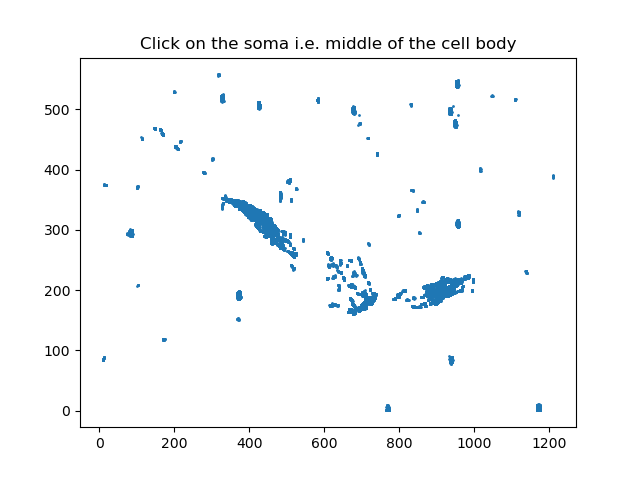

In [5]:
#Choose the location of the soma
x = neuron.dfs['X_(px)']
y = neuron.dfs['Y_(px)']

subplot_kw = dict(xlim=(0, 1), ylim=(0, 1), autoscale_on=True)
fig, ax = plt.subplots(subplot_kw=subplot_kw)

pts = ax.scatter(x, y, s=1)

soma_coords = []

def onclick(event):
    global soma_coords
    
    if event.inaxes:
        soma_coords.append((event.xdata, event.ydata))
        ax.plot(soma_coords[0][0],soma_coords[0][1], 'ro')
        ax.set_title(f"Coordinates are {round(soma_coords[0][0],2)},{round(soma_coords[0][1],2)}")
        fig.canvas.mpl_disconnect(cid)

cid1 = fig.canvas.mpl_connect('button_press_event', onclick)
ax.set_title("Click on the soma i.e. middle of the cell body")
plt.show()

In [6]:
print(soma_coords)

[(641.2954175380585, 217.44114433987943)]


In [7]:
neuron.filter_for_angle(minduration=4, actually_filter=True)
neuron.divide_two_directions(soma_coords=soma_coords)
neuron.split_tracks()

Filtering for angle....
Warning turned of : pd.options.mode.chained_assignment = None
Filtered for angle, all stretches of tracks below 50 were removed and strecthec shorted than 4 frames as well, the index is reset such that each stretch becomes a track on its own
The number of stretches after filtering for angle and splitting tracks: 1660
Mean localisation error: X: 8.35 nm Y: 8.14 nm
number of localisations toward soma 7083
number of localisations away from soma 7637
Ratio in over total 0.48
Results_filtered.csv
Results_RT.csv
Results_RB.csv
Results_LT.csv
Results_LB.csv
Results_PLUSIN.csv
Results_PLUSOUT.csv


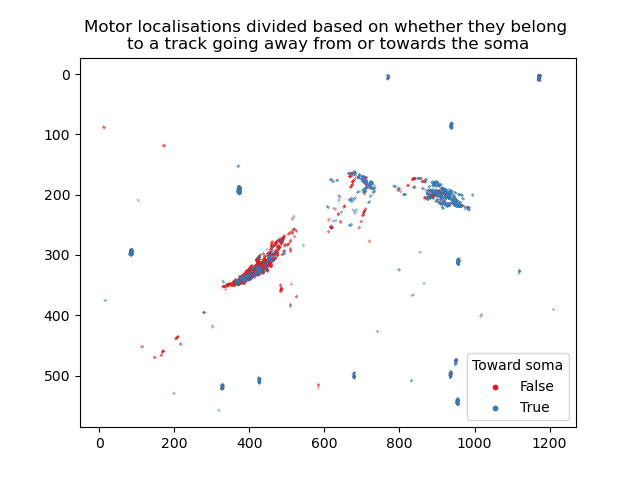

In [8]:
%matplotlib widget
sns.set_palette('Set1')
groups = neuron.dfs.groupby('Plus_IN')
for name, group in groups:
    plt.scatter(group['X_(px)'], group['Y_(px)'], marker='o', s=0.01, label=name)
plt.title("Motor localisations divided based on whether they belong \nto a track going away from or towards the soma")
lgnd=plt.legend(title="Toward soma")
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
#Note the y-axis is inverted so that the image is the same as when plotted in Fiji
plt.gca().invert_yaxis()
plt.show()

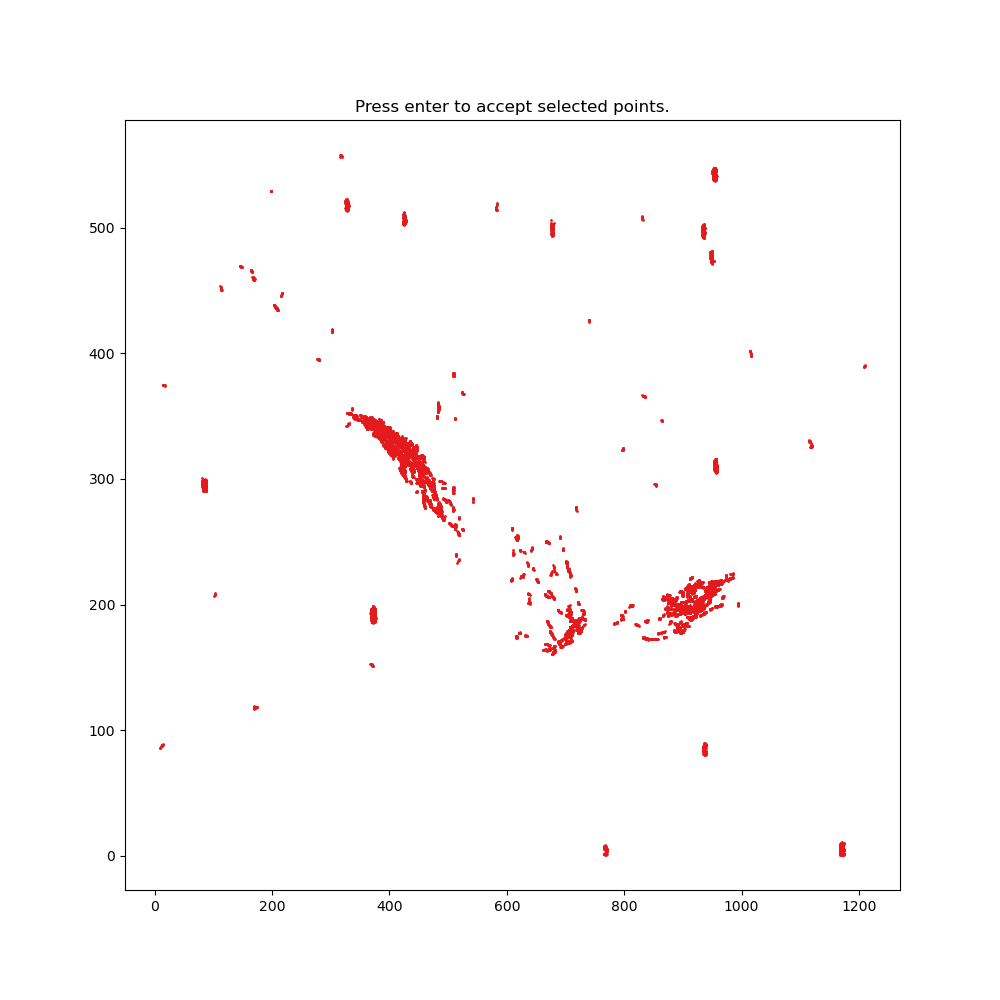

In [9]:
%matplotlib widget
DFS = neuron.dfs.copy()
x = neuron.dfs['X_(px)']
y = neuron.dfs['Y_(px)']

keys = ['X_(px)', 'Y_(px)']
    
subplot_kw = dict(xlim=(0, 1), ylim=(0, 1), autoscale_on=True)
fig, ax = plt.subplots(subplot_kw=subplot_kw, figsize=(10,10))

pts = ax.scatter(x, y, s=1)
ls.selector = ls.SelectFromCollection(ax, pts)

n = 0
neurites = {}
neuron_mdf = pd.DataFrame()
def accept(event):
    if event.key == "enter":
              
        global n     
        global data_points
        global neurite_df
        global neuron_mdf
        n = n+1    
        data_points = ls.selector.xys[ls.selector.ind].data
        
        neurites[n] = data_points
        df1 = pd.DataFrame(data_points, columns=keys)
        i1 = DFS.set_index(keys).index
        i2 = df1.set_index(keys).index
        neurite_df = DFS[i1.isin(i2)]
        neurite_df['Neurite_label'] = n
        neuron_mdf = pd.concat([neuron_mdf,neurite_df])    
    elif event.key == "shift":          
        ls.selector.disconnect()
        ax.set_title("DONE")
        fig.canvas.draw()
        fig.canvas.mpl_disconnect(cid)

cid = fig.canvas.mpl_connect("key_press_event", accept)
ax.set_title("Press enter to accept selected points.")
plt.show()

In [10]:
#neuron_mdf = pd.concat([neuron_mdf, neuron_mdf_f])

In [11]:
Results_PLUSIN = neuron_mdf[(neuron_mdf['Plus_IN']==True)]
number_of_localisations_IN = len(Results_PLUSIN.index.unique())
print('number of localisations toward soma', round(number_of_localisations_IN, 2))
    
Results_PLUSOUT = neuron_mdf[(neuron_mdf['Plus_IN']==False)]
number_of_localisations_OUT = len(Results_PLUSOUT.index.unique())
print('number of localisations away from soma', round(number_of_localisations_OUT, 2))
             
plusin_overtotal = round(number_of_localisations_IN/(number_of_localisations_OUT+number_of_localisations_IN), 2)

print(f'Ratio in over total {plusin_overtotal}')

number of localisations toward soma 389
number of localisations away from soma 601
Ratio in over total 0.39


In [12]:
#Color palette for plotting
sns.set_palette('tab20')
current_palette=sns.color_palette()
colors=current_palette.as_hex()

Percentage plus end in over total 38.51 %


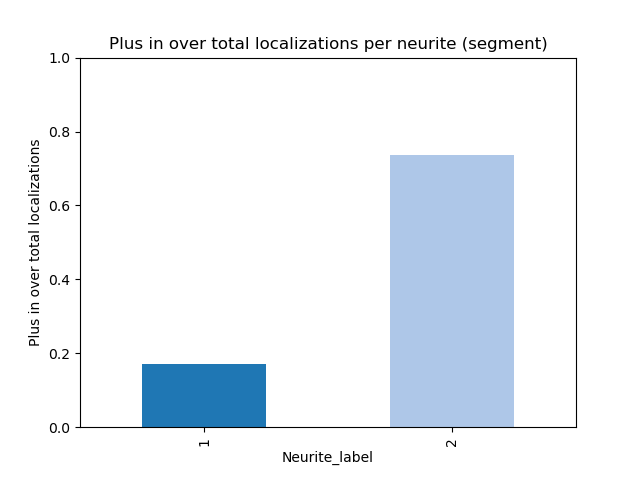

In [13]:
plusin_over_total = neuron_mdf.groupby(neuron_mdf.Neurite_label)['Plus_IN'].sum()/neuron_mdf.groupby(neuron_mdf.Neurite_label)['Plus_IN'].count()
%matplotlib widget
print('Percentage plus end in over total', round((neuron_mdf['Plus_IN'].sum()/neuron_mdf['Plus_IN'].count())*100,2), '%')
plusin_over_total.plot.bar(color=colors)
plt.ylabel('Plus in over total localizations')
plt.title('Plus in over total localizations per neurite (segment)')
plt.ylim([0,1])
plt.show()

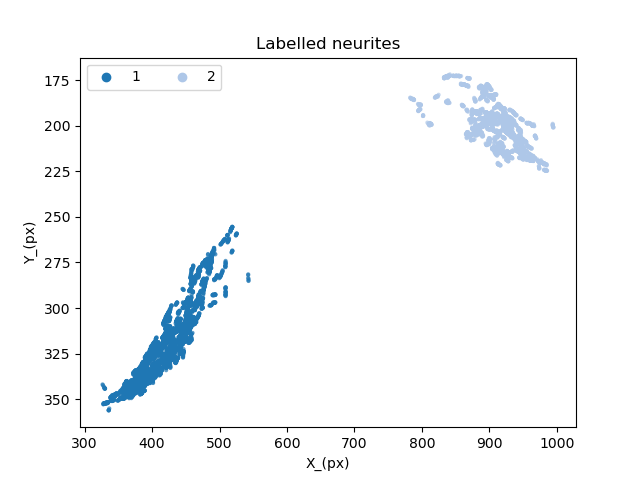

In [14]:
%matplotlib widget
sns.scatterplot(x=neuron_mdf['X_(px)'], y=neuron_mdf['Y_(px)'], hue=neuron_mdf['Neurite_label'], marker='.', linewidth=0, alpha=0.7, palette=colors[0:len(neuron_mdf['Neurite_label'].unique())])
plt.gca().invert_yaxis()
plt.title('Labelled neurites')
plt.legend(ncol=2)
plt.show()

In [15]:
neuron_mdf['Neurite_label'] = np.where(neuron_mdf.Neurite_label>13, neuron_mdf.Neurite_label-1, neuron_mdf.Neurite_label)

0.4531042090042026


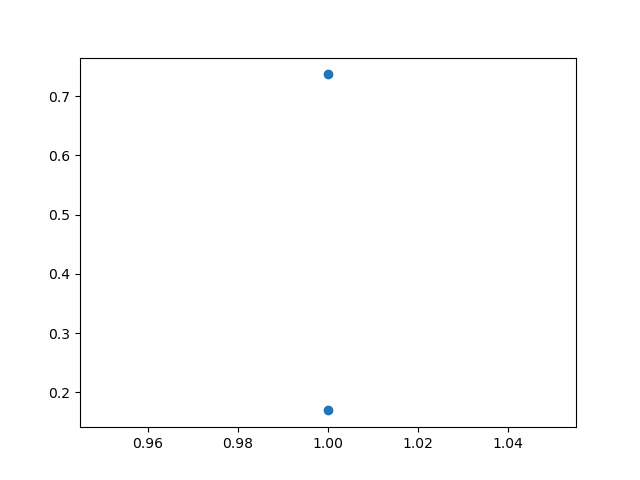

In [16]:
%matplotlib widget
ar = plusin_over_total.to_numpy()
print(ar.mean())
plt.plot(len(ar)*[1],ar, 'o');

In [17]:
#save the data frame with neurite labels as csv
name = os.getcwd().rsplit('\\', 1)[1]
neuron_mdf.to_csv('Data_frame_neurites_labelled_' + name + '.csv')